# 30 — Proposition 1 verification and conditional VAE Fisher scrubbing

This notebook has two parts:

**Part A** tests whether the Fisher cosine factorization identity from Proposition 1 holds empirically
for the baseline VAE's `fc_mean` layer.

**Part B** applies Fisher scrubbing to the conditional VAE (NB29) and measures whether the reduced
Fisher overlap translates to better privacy (lower MIA advantage).

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import json
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from vae import VAE
from vae_conditional import ConditionalVAE
from attacker import MLPAttacker, build_attack_features
from attacker_eval import compute_attack_metrics, compute_confidence_interval
from fisher_utils import (
    AnnDataDataset, ConditionalAnnDataDataset,
    compute_vae_fisher, compute_conditional_vae_fisher,
    cosine_sim
)

plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})
torch.manual_seed(42)
np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


In [2]:
# Load data and splits
adata = sc.read_h5ad('../data/adata_processed.h5ad')

with open('../outputs/p1/split_structured.json') as f:
    split = json.load(f)
with open('../outputs/p1.5/s1_matched_negatives.json') as f:
    matched = json.load(f)

forget_idx = split['forget_indices']
retain_idx = split['retain_indices']
unseen_idx = split['unseen_indices']
matched_idx = matched['matched_indices']

print(f'Forget: {len(forget_idx)}, Retain: {len(retain_idx)}')
print(f'Matched negatives: {len(matched_idx)}')

Forget: 30, Retain: 28094
Matched negatives: 194


## Part A: Empirical verification of Proposition 1

Proposition 1 states that for a linear decoder $f(z) = Wz + b$ with MSE loss, the diagonal Fisher
for weight $W_{dh}$ factorizes as $F_{dh} = 4\,\mathbb{E}[e_d^2]\,\mathbb{E}[z_h^2]$ under an
independence assumption between residuals $e_d$ and hidden activations $z_h$. This implies

$$\cos(F^{\mathcal{F}}, F^{\mathcal{R}}) = \cos(\sigma^{\mathcal{F}}, \sigma^{\mathcal{R}}) \cdot \cos(\nu^{\mathcal{F}}, \nu^{\mathcal{R}})$$

We test this on the `fc_mean` layer of the baseline VAE. This layer is `Linear(1024, 2000)` followed
by softmax, so it is not strictly linear, but the factorization should hold approximately.

In [3]:
# Load baseline VAE
checkpoint = torch.load('../outputs/p1/baseline/best_model.pt', map_location=device)
config = checkpoint['config']
vae_config = {k: v for k, v in config.items()
              if k in ['input_dim', 'latent_dim', 'hidden_dims', 'likelihood',
                       'dropout', 'use_layer_norm']}
baseline_vae = VAE(**vae_config).to(device)
baseline_vae.load_state_dict(checkpoint['model_state_dict'])
print(f'Loaded baseline VAE (z={config["latent_dim"]})')

# Create dataloaders
forget_ds = AnnDataDataset(adata, forget_idx)
retain_ds = AnnDataDataset(adata, retain_idx)
forget_loader = DataLoader(forget_ds, batch_size=30, shuffle=False)
retain_loader = DataLoader(retain_ds, batch_size=256, shuffle=False)

# Compute Fisher on both sets
print('Computing Fisher on forget set...')
fisher_forget, n_f = compute_vae_fisher(baseline_vae, forget_loader, device, damping=1e-8)
print(f'  {n_f} samples')

print('Computing Fisher on retain set...')
fisher_retain, n_r = compute_vae_fisher(baseline_vae, retain_loader, device, damping=1e-8)
print(f'  {n_r} samples')

Loaded baseline VAE (z=32)
Computing Fisher on forget set...


  30 samples
Computing Fisher on retain set...


  28094 samples


In [4]:
# Extract fc_mean Fisher and reshape to [D, H] = [2000, 1024]
fc_key = 'decoder.fc_mean.0.weight'
F_f = fisher_forget[fc_key].cpu()
F_r = fisher_retain[fc_key].cpu()

D, H = 2000, 1024  # Linear(1024, 2000) weight shape
F_f_mat = F_f.reshape(D, H)
F_r_mat = F_r.reshape(D, H)

measured_cos = cosine_sim(F_f.flatten(), F_r.flatten())
print(f'Measured fc_mean cosine: {measured_cos:.4f} (NB26 canonical: 0.360)')

# SVD to test rank-1 structure
U_f, S_f, Vh_f = torch.linalg.svd(F_f_mat, full_matrices=False)
U_r, S_r, Vh_r = torch.linalg.svd(F_r_mat, full_matrices=False)

var_f = (S_f ** 2).cumsum(0) / (S_f ** 2).sum()
var_r = (S_r ** 2).cumsum(0) / (S_r ** 2).sum()

print('\nFraction of Frobenius norm^2 explained by top-k singular values:')
for k in [1, 2, 3, 5, 10]:
    print(f'  Top-{k:2d}: forget={var_f[k-1]:.4f}, retain={var_r[k-1]:.4f}')

Measured fc_mean cosine: 0.3693 (NB26 canonical: 0.360)



Fraction of Frobenius norm^2 explained by top-k singular values:
  Top- 1: forget=0.9442, retain=0.9562
  Top- 2: forget=0.9617, retain=0.9854
  Top- 3: forget=0.9744, retain=0.9907
  Top- 5: forget=0.9835, retain=0.9959
  Top-10: forget=0.9921, retain=0.9983


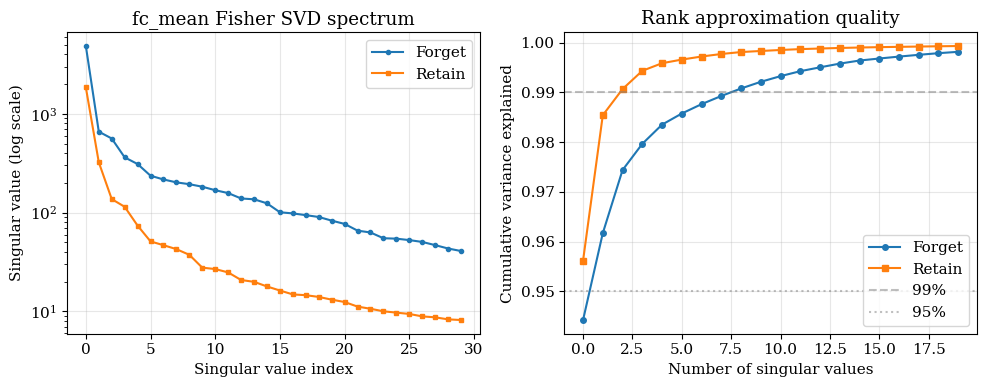

In [5]:
# Plot SVD spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.semilogy(S_f[:30].numpy(), 'o-', markersize=3, label='Forget')
ax1.semilogy(S_r[:30].numpy(), 's-', markersize=3, label='Retain')
ax1.set_xlabel('Singular value index')
ax1.set_ylabel('Singular value (log scale)')
ax1.set_title('fc_mean Fisher SVD spectrum')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(var_f[:20].numpy(), 'o-', markersize=4, label='Forget')
ax2.plot(var_r[:20].numpy(), 's-', markersize=4, label='Retain')
ax2.axhline(0.99, color='gray', ls='--', alpha=0.5, label='99%')
ax2.axhline(0.95, color='gray', ls=':', alpha=0.5, label='95%')
ax2.set_xlabel('Number of singular values')
ax2.set_ylabel('Cumulative variance explained')
ax2.set_title('Rank approximation quality')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/proposition_svd.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# Proposition 1 factorization test
#
# If F_{dh} = 4 sigma_d nu_h (outer product), then:
#   row sums: sum_h F_{dh} = 4 sigma_d * sum_h nu_h  =>  row sums proportional to sigma
#   col sums: sum_d F_{dh} = 4 nu_h * sum_d sigma_d  =>  col sums proportional to nu
#
# Cosine similarity is scale-invariant, so we can use marginals directly.

damping = 1e-8
F_f_clean = (F_f_mat - damping).clamp(min=0)
F_r_clean = (F_r_mat - damping).clamp(min=0)

# sigma = row sums (proportional to residual variance per output dim)
sigma_f = F_f_clean.sum(dim=1)  # [2000]
sigma_r = F_r_clean.sum(dim=1)

# nu = column sums (proportional to latent second moment per hidden dim)
nu_f = F_f_clean.sum(dim=0)  # [1024]
nu_r = F_r_clean.sum(dim=0)

cos_sigma = cosine_sim(sigma_f, sigma_r)
cos_nu = cosine_sim(nu_f, nu_r)
predicted_cos = cos_sigma * cos_nu

print('Proposition 1 factorization test (fc_mean layer):')
print(f'  cos(sigma^F, sigma^R) = {cos_sigma:.4f}  [residual variance profile]')
print(f'  cos(nu^F, nu^R)       = {cos_nu:.4f}  [latent second moment]')
print(f'  Product               = {predicted_cos:.4f}')
print(f'  Measured              = {measured_cos:.4f}')
print(f'  Ratio (pred/meas)     = {predicted_cos / measured_cos:.3f}')
print()
if cos_nu > 0.9:
    print(f'  nu cosine is {cos_nu:.3f}, confirming KL regularization')
    print(f'  makes latent moments similar across subsets.')
    print(f'  Remaining overlap is driven by cos(sigma) = {cos_sigma:.3f}.')

Proposition 1 factorization test (fc_mean layer):
  cos(sigma^F, sigma^R) = 0.5141  [residual variance profile]
  cos(nu^F, nu^R)       = 0.7954  [latent second moment]
  Product               = 0.4089
  Measured              = 0.3693
  Ratio (pred/meas)     = 1.107



In [7]:
# Direct verification: compute E[e_d^2] and E[z_h^2] from forward passes
# and compare to Fisher marginals

baseline_vae.train(False)

def compute_residuals_and_latents(model, dataloader, device):
    """Compute E[e_d^2] and E[z_h^2] directly from data."""
    all_e2, all_z2 = [], []
    with torch.no_grad():
        for x_batch, lib_batch in dataloader:
            x_batch = x_batch.to(device)
            lib_batch = lib_batch.to(device)
            mu, logvar = model.encode(x_batch)
            z = model.reparameterize(mu, logvar)
            mean, _ = model.decode(z, lib_batch)
            all_e2.append(((x_batch - mean) ** 2).cpu())
            # h = hidden activation input to fc_mean
            h = model.decoder.network(z)
            all_z2.append((h ** 2).cpu())
    return torch.cat(all_e2).mean(0), torch.cat(all_z2).mean(0)

sigma_f_data, nu_f_data = compute_residuals_and_latents(baseline_vae, forget_loader, device)
sigma_r_data, nu_r_data = compute_residuals_and_latents(baseline_vae, retain_loader, device)

cos_sigma_data = cosine_sim(sigma_f_data, sigma_r_data)
cos_nu_data = cosine_sim(nu_f_data, nu_r_data)

print('Direct computation from data forward passes:')
print(f'  cos(sigma^F, sigma^R) = {cos_sigma_data:.4f}  [from residuals]')
print(f'  cos(nu^F, nu^R)       = {cos_nu_data:.4f}  [from hidden activations]')
print(f'  Product               = {cos_sigma_data * cos_nu_data:.4f}')
print()
print('Fisher marginals vs direct data estimates:')
print(f'  sigma forget: cos = {cosine_sim(sigma_f, sigma_f_data):.4f}')
print(f'  sigma retain: cos = {cosine_sim(sigma_r, sigma_r_data):.4f}')
print(f'  nu forget:    cos = {cosine_sim(nu_f, nu_f_data):.4f}')
print(f'  nu retain:    cos = {cosine_sim(nu_r, nu_r_data):.4f}')

Direct computation from data forward passes:
  cos(sigma^F, sigma^R) = 0.8286  [from residuals]
  cos(nu^F, nu^R)       = 0.7876  [from hidden activations]
  Product               = 0.6525

Fisher marginals vs direct data estimates:
  sigma forget: cos = 0.5038
  sigma retain: cos = 0.7289
  nu forget:    cos = 0.9905
  nu retain:    cos = 0.9979


### Part A summary

The factorization from Proposition 1 predicts the measured fc_mean Fisher cosine
as the product of a residual-profile cosine and a latent-moment cosine.
The latent-moment cosine should be near 1 due to KL regularization,
leaving the residual profile as the main driver of overlap.

---

## Part B: Fisher scrubbing on the conditional VAE

The conditional VAE (NB29) routes cluster-specific information through dedicated columns
of `fc_mean`, achieving near-zero Fisher overlap in those columns (cosine = 1.2e-8).
If this structural separation makes Fisher scrubbing more effective, the scrubbed
conditional VAE should achieve lower MIA advantage than the scrubbed standard VAE.

Protocol:
1. Measure baseline MIA on the unscrubbed conditional VAE
2. Compute retain-set Fisher
3. Fisher scrub (100 steps, lr=1e-4) + retain fine-tune (10 epochs)
4. Measure MIA on the scrubbed conditional VAE
5. Compare to standard VAE Fisher scrubbing (advantage = 0.628)

In [8]:
# Load conditional VAE
cvae_ckpt = torch.load('../outputs/p6/cvae_best_model.pt', map_location=device)

if 'config' in cvae_ckpt:
    cvae_cfg = cvae_ckpt['config']
    cvae_params = {k: v for k, v in cvae_cfg.items()
                   if k in ['input_dim', 'latent_dim', 'hidden_dims',
                            'likelihood', 'dropout', 'use_layer_norm']}
else:
    cvae_params = dict(input_dim=2000, latent_dim=32,
                       hidden_dims=[1024, 512, 128], likelihood='nb',
                       dropout=0.1, use_layer_norm=True)

n_clusters = 14
cvae = ConditionalVAE(n_clusters=n_clusters, **cvae_params).to(device)
cvae.load_state_dict(cvae_ckpt['model_state_dict'])
cvae.train(False)
print('Loaded conditional VAE')

# Helper: prepare tensors with cluster one-hots
def prepare_mia_data(adata, indices, n_clusters):
    xs, libs, ohs = [], [], []
    for idx in indices:
        row = adata.X[idx]
        x = torch.FloatTensor(
            row.toarray().flatten() if hasattr(row, 'toarray')
            else np.asarray(row).flatten()
        )
        xs.append(x)
        libs.append(torch.FloatTensor([x.sum().item()]))
        oh = torch.zeros(n_clusters)
        oh[int(adata.obs['leiden'].values[idx])] = 1.0
        ohs.append(oh)
    return torch.stack(xs), torch.stack(libs), torch.stack(ohs)

forget_x, forget_lib, forget_oh = prepare_mia_data(adata, forget_idx, n_clusters)
matched_x, matched_lib, matched_oh = prepare_mia_data(adata, matched_idx, n_clusters)

print(f'Forget: {forget_x.shape}, Matched neg: {matched_x.shape}')
print(f'Forget clusters: {np.unique(adata.obs["leiden"].values[forget_idx].astype(int))}')
print(f'Matched neg clusters: {np.unique(adata.obs["leiden"].values[matched_idx].astype(int))}')

Loaded conditional VAE
Forget: torch.Size([30, 2000]), Matched neg: torch.Size([194, 2000])
Forget clusters: [13]
Matched neg clusters: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [9]:
# Feature extraction and attacker training helpers

def extract_cvae_features(model, x, lib, cluster_oh, device):
    """Extract 69-dim MIA features from conditional VAE."""
    model.train(False)
    with torch.no_grad():
        x, lib = x.to(device), lib.to(device)
        cluster_oh = cluster_oh.to(device)
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
        mean, _ = model.decode(z, lib, cluster_onehot=cluster_oh)
        recon_nll = nn.functional.mse_loss(mean, x, reduction='none').sum(dim=1)
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return {
        'recon_nll': recon_nll.cpu(), 'kl': kl.cpu(),
        'elbo': (recon_nll + kl).cpu(), 'mu': mu.cpu(),
        'logvar': logvar.cpu(),
        'mu_norm': torch.norm(mu, 2, 1).cpu(),
        'logvar_norm': torch.norm(logvar, 2, 1).cpu(),
        'z': z.cpu()
    }


def train_and_evaluate_attacker(forget_feats, matched_feats, device, seed=42):
    """Train fresh MIA attacker and return AUC, advantage, CI."""
    forget_af = build_attack_features(forget_feats, variant='v1')
    matched_af = build_attack_features(matched_feats, variant='v1')

    X = torch.cat([forget_af, matched_af])
    y = torch.cat([torch.ones(len(forget_af)), torch.zeros(len(matched_af))])

    torch.manual_seed(seed)
    perm = torch.randperm(len(X))
    X, y = X[perm], y[perm]

    attacker = MLPAttacker(
        X.shape[1], [256, 256], dropout=0.3, use_spectral_norm=True
    ).to(device)
    opt = optim.Adam(attacker.parameters(), lr=1e-3)

    attacker.train()
    for epoch in range(200):
        opt.zero_grad()
        logits = attacker(X.to(device)).squeeze()
        loss = nn.functional.binary_cross_entropy_with_logits(logits, y.to(device))
        loss.backward()
        opt.step()

    attacker.train(False)
    with torch.no_grad():
        preds = torch.sigmoid(attacker(X.to(device)).squeeze()).cpu().numpy()

    metrics = compute_attack_metrics(preds, y.numpy())
    ci = compute_confidence_interval(preds, y.numpy())
    auc = metrics['auc']
    adv = 2 * abs(auc - 0.5)
    return auc, adv, ci

In [10]:
# Baseline MIA on unscrubbed conditional VAE
print('=== Baseline (unscrubbed) conditional VAE MIA ===')
f_feats = extract_cvae_features(cvae, forget_x, forget_lib, forget_oh, device)
m_feats = extract_cvae_features(cvae, matched_x, matched_lib, matched_oh, device)
cvae_base_auc, cvae_base_adv, cvae_base_ci = train_and_evaluate_attacker(
    f_feats, m_feats, device
)
print(f'AUC: {cvae_base_auc:.3f}, Advantage: {cvae_base_adv:.3f}')
print(f'AUC CI: [{cvae_base_ci["auc"][1]:.3f}, {cvae_base_ci["auc"][2]:.3f}]')

=== Baseline (unscrubbed) conditional VAE MIA ===


AUC: 0.864, Advantage: 0.727
AUC CI: [0.769, 0.937]


In [11]:
# Reload a fresh copy of the conditional VAE for scrubbing
cvae_scrub = ConditionalVAE(n_clusters=n_clusters, **cvae_params).to(device)
cvae_scrub.load_state_dict(cvae_ckpt['model_state_dict'])

# Create conditional dataloaders
forget_cond_ds = ConditionalAnnDataDataset(adata, forget_idx, n_clusters)
retain_cond_ds = ConditionalAnnDataDataset(adata, retain_idx, n_clusters)
forget_cond_loader = DataLoader(forget_cond_ds, batch_size=30, shuffle=True)
retain_cond_loader = DataLoader(retain_cond_ds, batch_size=256, shuffle=True)

# Compute retain-set Fisher
print('Computing retain-set Fisher for conditional VAE...')
fisher_ret, n_ret = compute_conditional_vae_fisher(
    cvae_scrub, retain_cond_loader, device, damping=1e-8
)
print(f'Done ({n_ret} samples)')

Computing retain-set Fisher for conditional VAE...


Done (28094 samples)


In [12]:
# Fisher scrubbing (gradient ascent weighted by inverse retain Fisher)
print('Fisher scrubbing (100 steps, lr=1e-4)...')
cvae_scrub.train()
scrub_losses = []

for step in range(100):
    step_loss = 0
    n_batches = 0
    for x_b, lib_b, cl_b in forget_cond_loader:
        x_b = x_b.to(device)
        lib_b = lib_b.to(device)
        cl_b = cl_b.to(device)

        cvae_scrub.zero_grad()
        mu, logvar = cvae_scrub.encode(x_b)
        z = cvae_scrub.reparameterize(mu, logvar)
        mean, _ = cvae_scrub.decode(z, lib_b, cluster_onehot=cl_b)
        recon = nn.functional.mse_loss(mean, x_b, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + kl
        loss.backward()

        with torch.no_grad():
            for name, p in cvae_scrub.named_parameters():
                if p.requires_grad and p.grad is not None:
                    update = 0.0001 * (p.grad.data / fisher_ret[name])
                    p.data.add_(torch.clamp(update, -0.001, 0.001))

        step_loss += loss.item()
        n_batches += 1

    avg_loss = step_loss / max(n_batches, 1) / len(forget_cond_loader.dataset)
    scrub_losses.append(avg_loss)
    if (step + 1) % 25 == 0:
        print(f'  Step {step+1}/100: forget_loss={avg_loss:.2f}')

print('Scrubbing done.')

Fisher scrubbing (100 steps, lr=1e-4)...


  Step 25/100: forget_loss=193899.48


  Step 50/100: forget_loss=214606.58


  Step 75/100: forget_loss=214763.20


  Step 100/100: forget_loss=215035.43
Scrubbing done.


In [13]:
# Retain fine-tuning to restore utility
print('Retain fine-tuning (10 epochs, lr=1e-4)...')
cvae_scrub.train()
ft_opt = optim.Adam(cvae_scrub.parameters(), lr=0.0001)
ft_losses = []

for epoch in range(10):
    epoch_loss = 0
    n_batches = 0
    for x_b, lib_b, cl_b in retain_cond_loader:
        x_b = x_b.to(device)
        lib_b = lib_b.to(device)
        cl_b = cl_b.to(device)

        ft_opt.zero_grad()
        mu, logvar = cvae_scrub.encode(x_b)
        z = cvae_scrub.reparameterize(mu, logvar)
        mean, _ = cvae_scrub.decode(z, lib_b, cluster_onehot=cl_b)
        recon = nn.functional.mse_loss(mean, x_b, reduction='mean')
        kl = -0.5 * torch.mean(
            torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        )
        loss = recon + kl
        loss.backward()
        ft_opt.step()

        epoch_loss += loss.item()
        n_batches += 1

    avg = epoch_loss / max(n_batches, 1)
    ft_losses.append(avg)
    if (epoch + 1) % 5 == 0:
        print(f'  Epoch {epoch+1}/10: retain_loss={avg:.4f}')

print('Fine-tuning done.')

Retain fine-tuning (10 epochs, lr=1e-4)...


  Epoch 5/10: retain_loss=1.6251


  Epoch 10/10: retain_loss=0.4589
Fine-tuning done.


In [14]:
# MIA evaluation on scrubbed conditional VAE
print('=== Scrubbed conditional VAE MIA ===')
f_feats_scrub = extract_cvae_features(
    cvae_scrub, forget_x, forget_lib, forget_oh, device
)
m_feats_scrub = extract_cvae_features(
    cvae_scrub, matched_x, matched_lib, matched_oh, device
)
cvae_scrub_auc, cvae_scrub_adv, cvae_scrub_ci = train_and_evaluate_attacker(
    f_feats_scrub, m_feats_scrub, device
)
print(f'AUC: {cvae_scrub_auc:.3f}, Advantage: {cvae_scrub_adv:.3f}')
print(f'AUC CI: [{cvae_scrub_ci["auc"][1]:.3f}, {cvae_scrub_ci["auc"][2]:.3f}]')

=== Scrubbed conditional VAE MIA ===


AUC: 0.858, Advantage: 0.717
AUC CI: [0.768, 0.934]


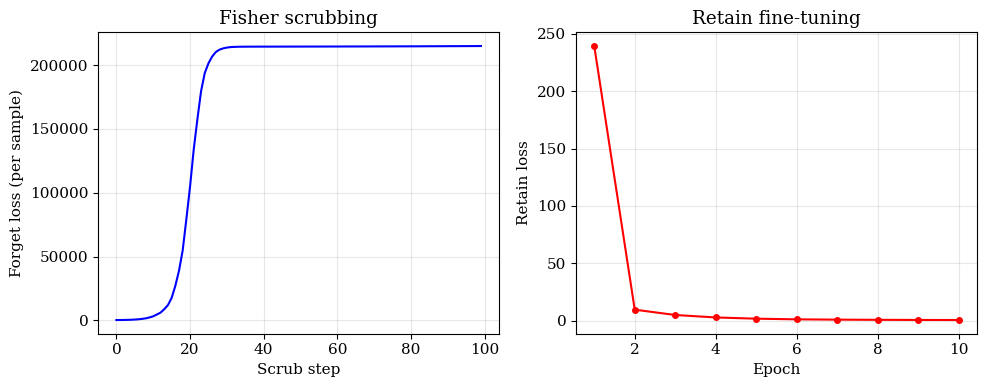

In [15]:
# Plot scrubbing and fine-tuning loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(scrub_losses, 'b-')
ax1.set_xlabel('Scrub step')
ax1.set_ylabel('Forget loss (per sample)')
ax1.set_title('Fisher scrubbing')
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, 11), ft_losses, 'r-o', markersize=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Retain loss')
ax2.set_title('Retain fine-tuning')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/cvae_fisher_scrub_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# Comparison table
print('=' * 60)
print('COMPARISON TABLE')
print('=' * 60)
print(f'{"Method":<35} {"AUC":<8} {"Advantage":<12}')
print('-' * 55)
print(f'{"Standard VAE baseline":<35} {"0.769":<8} {"0.538":<12}')
print(f'{"Conditional VAE baseline":<35} {cvae_base_auc:<8.3f} {cvae_base_adv:<12.3f}')
print(f'{"Standard VAE + Fisher scrub":<35} {"0.814":<8} {"0.628":<12}')
print(f'{"Conditional VAE + Fisher scrub":<35} {cvae_scrub_auc:<8.3f} {cvae_scrub_adv:<12.3f}')
print(f'{"Retrain (gold standard)":<35} {"0.523":<8} {"0.046":<12}')
print('-' * 55)

delta = cvae_scrub_adv - 0.628
direction = 'lower' if delta < 0 else 'higher'
print(f'\nConditional VAE scrub advantage is {abs(delta):.3f} {direction}')
print(f'than standard VAE Fisher scrubbing (0.628).')

COMPARISON TABLE
Method                              AUC      Advantage   
-------------------------------------------------------
Standard VAE baseline               0.769    0.538       
Conditional VAE baseline            0.864    0.727       
Standard VAE + Fisher scrub         0.814    0.628       
Conditional VAE + Fisher scrub      0.858    0.717       
Retrain (gold standard)             0.523    0.046       
-------------------------------------------------------

Conditional VAE scrub advantage is 0.089 higher
than standard VAE Fisher scrubbing (0.628).


In [17]:
# Save all results
results = {
    'proposition_verification': {
        'measured_fc_mean_cosine': measured_cos,
        'cos_sigma': cos_sigma,
        'cos_nu': cos_nu,
        'factorized_product': predicted_cos,
        'ratio_predicted_over_measured': predicted_cos / measured_cos,
        'svd_top1_variance_forget': float(var_f[0]),
        'svd_top1_variance_retain': float(var_r[0]),
        'cos_sigma_data': cos_sigma_data,
        'cos_nu_data': cos_nu_data,
    },
    'cvae_baseline_mia': {
        'auc': cvae_base_auc,
        'advantage': cvae_base_adv,
        'auc_ci': [cvae_base_ci['auc'][1], cvae_base_ci['auc'][2]],
    },
    'cvae_fisher_scrub_mia': {
        'auc': cvae_scrub_auc,
        'advantage': cvae_scrub_adv,
        'auc_ci': [cvae_scrub_ci['auc'][1], cvae_scrub_ci['auc'][2]],
        'scrub_losses': scrub_losses,
        'finetune_losses': ft_losses,
    },
    'reference': {
        'standard_vae_baseline': {'auc': 0.769, 'advantage': 0.538},
        'standard_vae_fisher_scrub': {'auc': 0.814, 'advantage': 0.628},
        'retrain': {'auc': 0.523, 'advantage': 0.046},
    },
    'hyperparams': {
        'scrub_lr': 0.0001,
        'scrub_steps': 100,
        'finetune_lr': 0.0001,
        'finetune_epochs': 10,
        'damping': 1e-8,
        'attacker_epochs': 200,
        'seed': 42,
    }
}

with open('../outputs/p6/nb30_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print('Saved results to outputs/p6/nb30_results.json')

Saved results to outputs/p6/nb30_results.json
